In [15]:
import random
import operator
import csv
import itertools
import math

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import csv
from elitism import eaSimpleWithElitism


import matplotlib.pyplot as plt

import networkx as nx

In [16]:
# Genetic Programming constants:
POPULATION_SIZE = 200
P_CROSSOVER = 0.9
P_MUTATION = 0.01
MAX_GENERATIONS = 50
HALL_OF_FAME_SIZE = 10

N_RUNS = 30

In [17]:
RANDOM_SEED = 412
random.seed(RANDOM_SEED)

In [18]:
MIN_TREE_HEIGHT = 5
MAX_TREE_HEIGHT = 12
LIMIT_TREE_HEIGHT = 17
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

## Read data

In [19]:
import pandas as pd

trainDf = pd.read_csv("./salustowicz_input_file.csv")
trainDf.head()

,Z1,TARGET
0,0.05,-0.000006
1,0.35,-0.008657
2,0.65,-0.048932
3,0.95,-0.096507
4,1.25,-0.119897


In [20]:
testDf = pd.read_csv("./salustowicz_test_dataset.csv")
testDf.head()   

,Z1,TARGET
0,-0.50,-0.069219
1,-0.45,-0.046438
2,-0.40,-0.029462
3,-0.35,-0.017433
4,-0.30,-0.009431


## Eval Function

In [21]:
def evalSymbReg(individual):
    ERROR_CEIL = 1000
    
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual) # type: ignore
    # Evaluate the mean squared error between the expression
    # and the real function : f(z) = e^{-z}z^{3}cos(z)sin(z)\left[cos(z)sin^{2}(z)-1\right]
    try:
        mse = 0.0
        for i in range(len(trainDf)):
            z = trainDf["Z1"][i]
            y = trainDf["TARGET"][i]
            mse += ((func(z) - y) ** 2) / len(trainDf)
            # ceil mse
            if mse > ERROR_CEIL:
                mse = ERROR_CEIL
    except OverflowError:
        mse = ERROR_CEIL
        
    if math.isnan(mse):
        mse = ERROR_CEIL

    nodes, _, _ = gp.graph(individual)
    return mse, len(nodes)

## Primatives

In [22]:
# Protected functions
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1


def psin(n):
    try:
        return numpy.sin(n)
    except Exception as e:
        print(f"Exception {e} in psin")
        return numpy.nan


def pcos(n):
    try:
        return numpy.cos(n)
    except Exception as e:
        print(f"Exception {e} in pcos")
        return numpy.nan


def pow2(n):
    try:
        return operator.pow(n, 2)
    except OverflowError as oe:
        print(f"Overflow in pow2: {n}^2")
        return numpy.nan

In [23]:
primativeSet = gp.PrimitiveSet("MAIN", 1)  # one input: Z1

primativeSet.addPrimitive(operator.add, 2)
primativeSet.addPrimitive(operator.sub, 2)
primativeSet.addPrimitive(operator.mul, 2)
primativeSet.addPrimitive(protectedDiv, 2)
primativeSet.addPrimitive(operator.neg, 1)

primativeSet.addPrimitive(psin, 1)
primativeSet.addPrimitive(pcos, 1)
primativeSet.addPrimitive(pow2, 1)

primativeSet.addEphemeralConstant("rand101", lambda: random.random())

/home/tu/micromamba/lib/python3.9/site-packages/deap/gp.py:254: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


## Toolbox

In [24]:
toolbox = base.Toolbox()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox.register("expr", gp.genHalfAndHalf, pset=primativeSet, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=primativeSet)

toolbox.register("evaluate", evalSymbReg)
toolbox.register("select", tools.selTournament, tournsize=5)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=primativeSet)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))

/home/tu/micromamba/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/tu/micromamba/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


## Statistic Holder

In [25]:
maxFitnessValues = []
minFitnessValues = []
avgFitnessValues = []
stdFitnessValues = []

maxSize = []
minSize = []
avgSize = []
stdSize = []

hofBest = tools.HallOfFame(1)

## Repeat run

In [26]:
for r in range(N_RUNS):
    population = toolbox.population(n=POPULATION_SIZE)
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    population, logbook = eaSimpleWithElitism(
        population,
        toolbox,
        cxpb=P_CROSSOVER,
        mutpb=P_MUTATION,
        ngen=MAX_GENERATIONS,
        stats=stats,
        halloffame=hof,
        verbose=True,
    )

    maxFitnessValues.append(logbook.chapters["gen"].select("max"))
    minFitnessValues.append(logbook.chapters["gen"].select("min"))
    avgFitnessValues.append(logbook.chapters["gen"].select("avg"))
    stdFitnessValues.append(logbook.chapters["gen"].select("std"))

    maxSize.append(logbook.chapters["size"].select("max"))
    minSize.append(logbook.chapters["size"].select("min"))
    avgSize.append(logbook.chapters["size"].select("avg"))
    stdSize.append(logbook.chapters["size"].select("std"))
    
    hofBest.update(hof.items)

/tmp/ipykernel_1033988/2158322065.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return left / right
/tmp/ipykernel_1033988/2158322065.py:11: RuntimeWarning: invalid value encountered in sin
  return numpy.sin(n)
/tmp/ipykernel_1033988/2158322065.py:19: RuntimeWarning: invalid value encountered in cos
  return numpy.cos(n)
/tmp/ipykernel_1033988/2158322065.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return left / right


gen	nevals	avg    	std    	min      	max 
0  	200   	269.536	387.599	0.0995199	1000
1  	172   	62.0566	175.86 	0.0995199	1000
2  	164   	47.3583	138.899	0.0923326	1000
3  	161   	81.0764	199.198	0.0923326	1000


<string>:1: RuntimeWarning: invalid value encountered in scalar add


4  	167   	89.2811	219.029	0.0770963	1000
5  	164   	70.6707	203.802	0.0752271	1000
6  	176   	55.0177	171.437	0.0675818	1000
7  	174   	33.0093	121.395	0.0573501	1000
8  	172   	16.5877	52.5451	0.0424592	1000
9  	166   	15.0229	51.3832	0.0424592	1000
10 	174   	12.4684	13.4548	0.0416907	52  
11 	169   	18.4986	71.1166	0.0378775	1000
12 	174   	19.3604	71.3246	0.0376815	1000
13 	170   	18.4681	52.07  	0.0371647	1000
14 	166   	16.854 	18.3391	0.0363925	81  
15 	180   	20.833 	52.9506	0.0355191	1000
16 	178   	27.6433	87.1591	0.0355191	1000
17 	174   	23.0514	53.3509	0.034728 	1000
18 	178   	23.7008	53.5476	0.034728 	1000
19 	166   	23.772 	53.5605	0.034728 	1000
20 	170   	23.9927	53.793 	0.0339999	1000
21 	182   	23.3073	53.6048	0.0339999	1000
22 	170   	22.106 	23.4563	0.0333377	123.22
23 	170   	22.666 	23.6349	0.0329857	73    
24 	180   	22.7066	24.2803	0.0329857	86    
25 	172   	25.4089	54.4518	0.032503 	1000  
26 	170   	23.7718	25.2762	0.032503 	85    
27 	176   	26.7646	55.08

<string>:1: RuntimeWarning: invalid value encountered in scalar subtract


gen	nevals	avg    	std    	min     	max 
0  	200   	269.236	392.288	0.100749	1000
1  	170   	67.6216	163.116	0.093575	1000
2  	174   	85.8672	158.299	0.093575	1000
3  	170   	99.6074	210.949	0.093575	1000
4  	177   	68.9779	195.419	0.0901651	1000
5  	166   	60.2247	197.413	0.0901651	1000
6  	174   	66.4794	203.926	0.0684032	1000
7  	165   	62.9903	203.61 	0.0592091	1000
8  	166   	79.111 	233.009	0.0442043	1000
9  	159   	62.9183	194.825	0.0248518	1000
10 	176   	69.1609	208.945	0.0248518	1000
11 	164   	73.3408	215.724	0.0240656	1000
12 	170   	76.2843	214.492	0.0240656	1000
13 	177   	83.9486	221.86 	0.0226629	1000
14 	176   	111.903	270.903	0.0198306	1000
15 	170   	88.3212	236.978	0.0198306	1000
16 	174   	107.599	268.896	0.017497 	1000
17 	162   	102.141	264.613	0.017497 	1000
18 	170   	128.066	298.656	0.017497 	1000
19 	172   	118.567	282.857	0.017497 	1000
20 	172   	111.003	283.877	0.0164203	1000
21 	172   	139.65 	314.248	0.0164203	1000
22 	178   	114.389	278.997	0.0164203	10

<string>:1: RuntimeWarning: invalid value encountered in scalar multiply


3  	168   	73.6126	205.557	0.0650535	1000
4  	178   	65.3628	210.154	0.0650535	1000
5  	174   	33.5173	119.954	0.0631297	1000
6  	168   	24.305 	72.6787	0.0631297	1000
7  	184   	28.7907	87.8737	0.0617811	1000
8  	178   	23.419 	26.7449	0.0599161	91  
9  	172   	34.6489	100.933	0.0582126	1000
10 	165   	29.6609	57.281 	0.056083 	1000
11 	170   	30.4576	58.4467	0.0539669	1000
12 	174   	36.7096	78.1592	0.0539669	1000
13 	173   	46.4796	114.939	0.0539669	1000
14 	178   	38.4461	44.2492	0.052989 	139 
15 	168   	42.0393	47.0318	0.0524027	143 
16 	176   	45.1394	81.725 	0.0524027	1000
17 	174   	42.7492	66.1241	0.0394646	1000
18 	162   	41.2672	46.5853	0.0394646	168 
19 	176   	41.8726	46.7689	0.0382799	167 
20 	164   	43.176 	46.8209	0.0342024	137 
21 	169   	45.7234	47.3762	0.0326014	148 
22 	175   	44.5773	46.5497	0.0323835	146 
23 	166   	46.0806	48.6351	0.0306868	150 
24 	170   	46.7501	50.5019	0.0306868	155 
25 	166   	51.574 	55.2827	0.0306868	165 
26 	176   	54.8972	58.1068	0.03068

/tmp/ipykernel_1033988/1338832600.py:13: RuntimeWarning: overflow encountered in scalar power
  mse += ((func(z) - y) ** 2) / len(trainDf)


gen	nevals	avg    	std    	min     	max 
0  	200   	236.635	368.232	0.101392	1000
1  	178   	61.6094	149.795	0.0823973	1000
2  	172   	79.3424	154.382	0.0823973	1000
3  	164   	92.4738	142.698	0.079012 	1000
4  	184   	81.5868	153.891	0.0566679	1000
5  	164   	54.4299	114.747	0.0510751	1000
6  	158   	27.5434	62.066 	0.0510751	1000
7  	166   	19.5967	72.0581	0.0510751	1000
8  	180   	15.767 	51.9181	0.0496922	1000
9  	167   	13.0132	14.5753	0.0478576	79  
10 	170   	15.6471	51.241 	0.0478576	1000
11 	168   	13.1368	13.9039	0.0478576	58  
12 	170   	15.7254	51.1944	0.0478296	1000
13 	164   	13.5342	14.3502	0.0478296	89.5524
14 	165   	13.4081	13.7849	0.0478296	53     
15 	166   	13.6683	14.1787	0.0478296	73.404 
16 	172   	16.6807	51.3201	0.0465023	1000   
17 	177   	14.1831	14.7168	0.046093 	51     
18 	170   	14.5483	14.9943	0.046093 	52.9639
19 	178   	17.3417	51.4824	0.0400612	1000   
20 	180   	15.8024	17.1124	0.0400612	98.9113
21 	180   	21.9508	71.6495	0.0400612	1000   
22 	172  

/tmp/ipykernel_1033988/2158322065.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return left / right


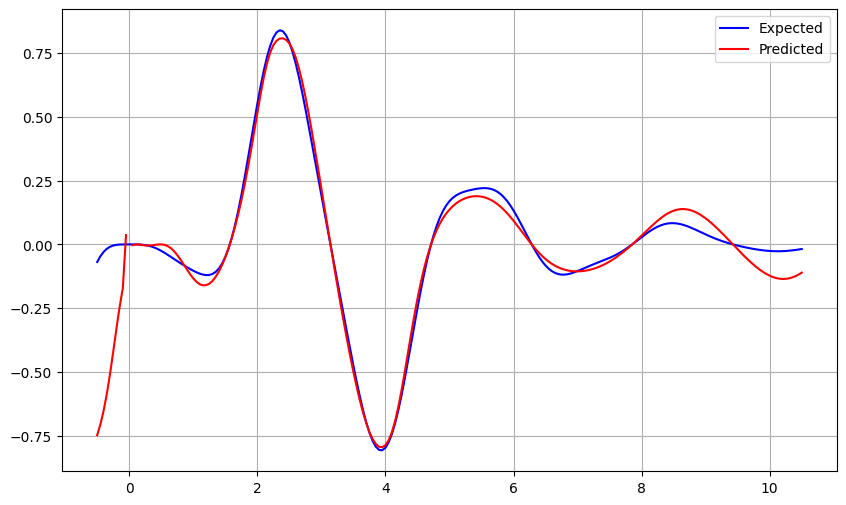

In [34]:
# use your best individual so far to plot a graph with its outputs, and plot the expected curve (from the dataset) in the same graph.

best = hofBest[0]

func = toolbox.compile(expr=best)

z1Values = testDf["Z1"].values
targetValues = testDf["TARGET"].values

plt.figure(figsize=(10, 6))
plt.plot(z1Values, targetValues, label="Expected", color="blue")

predictedValues = [func(z) for z in z1Values]
plt.plot(z1Values, predictedValues, label="Predicted", color="red")

plt.legend()
plt.grid(True)